#===============================================================================================================
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#------- Project: EVALUATION OF SQL INJECTION (SQLi) ATTACK DETECTION STRATEGIES IN WEB ------------------------
#------- APPLICATIONS USING MACHINE LEARNING -------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#------- By: Santiago Taborda Echeverri ------------------------------------------------------------------------
#-------     santiago.tabordae@udea.edu.co ---------------------------------------------------------------------
#-------     Telecommunications engineering student ------------------------------------------------------------
#-------     Cyber Security Analyst Intern at AizoOn Technology Consulting -------------------------------------
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#===============================================================================================================

In [1]:
import time
import utils
import numpy as np
import pandas as pd
from joblib import dump
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# File paths for input and output CSV files
mithril_total_file_path = 'mithril_total_logs.csv'
mithril_raw_file_path = 'mithril_SQLi_raw.csv'
mithril_extract_file_path = 'mithril_SQLi_Dataset.csv'

# Filter logs and extract relevant data
utils.filter_logs(mithril_total_file_path, mithril_raw_file_path)
utils.extract_data_waf(mithril_raw_file_path, mithril_extract_file_path)

df_waf = pd.read_csv(mithril_extract_file_path)         # Read the dataset into a pandas DataFrame

# Pre-process the 'Query' column using the function preprocess_input from the utils module custum .py
preprocess_column = df_waf['Query'].apply(utils.preprocess_input)
df_waf['preprocess_column'] = preprocess_column         # Add the pre-processed data as a new column

column_order = ['Query', 'preprocess_column', 'Label']  # Define the desired order of columns
df_waf = df_waf.reindex(columns=column_order)           # Reorder the DataFrame columns

In [3]:
kaggle_file_path = 'kaggle_SQL_Dataset.csv'             # Define the file path for the dataset

df_kaggle = pd.read_csv(kaggle_file_path)               # Read the dataset into a pandas DataFrame

# Pre-process the 'Query' column using the function preprocess_input from the utils module custum .py
preprocess_column = df_kaggle['Query'].apply(utils.preprocess_input)
df_kaggle['preprocess_column'] = preprocess_column      # Add the pre-processed data as a new column

column_order = ['Query', 'preprocess_column', 'Label']  # Define the desired order of columns
df_kaggle = df_kaggle.reindex(columns=column_order)     # Reorder the DataFrame columns

In [4]:
# Combine df_kaggle and df_waf into one DataFrame
df_integration = pd.concat([df_kaggle, df_waf], ignore_index=True)  

columns_to_keep = ["preprocess_column", "Label"]        # Specify columns to keep
df_integration = df_integration[columns_to_keep]        # Keep only the specified columns

df_integration                                          # Display the resulting DataFrame

,preprocess_column,Label
0,""" or pg _ sleep ( _ _ time _ _ ) - -",1
1,create user name identified by pass 0 tempora...,1
2,and 0 = utl _ inaddr . get _ host _ addre...,1
3,select * from users where id = ' 0 ' ...,1
4,select * from users where id = 0 or 0 ...,1
...,...,...
49487,"updatexml ( # , concat ( 0 , md 0 ( 0 )...",1
49488,"updatexml ( # , concat ( 0 , md 0 ( 0 )...",1
49489,"updatexml ( 0 , concat ( 0 xa , user ( ) ...",1
49490,"updatexml ( 0 , concat ( 0 xa , user ( ) ...",1


In [ ]:
# Vectorize the 'preprocess_column' using the NLP_transform function from utils with a balanced vectorizer model
df_result_vectorized = utils.NLP_transform(
    df_integration["preprocess_column"], 
    df_integration["Label"], 
    './balanced_models/vectorizer_duplicates.joblib'
)

# Separate features (X) and labels (y)
X = df_result_vectorized.drop(columns=['Label'])
y = df_result_vectorized['Label']

# Balance the data using the specified method, here 'RandomOverSampler'
X_balanced, y_balanced = utils.balancing_data(X, y, 'RandomOverSampler')

# Split the balanced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=1)

# Filter the training data to include only samples with label 1 for One-Class SVM training
X_train_OCSVM = X_train[y_train == 1]
y_train_OCSVM = y_train[y_train == 1]

result_table = []                          # Initialize an empty list to store results

main_path_images = './images/balanced/'    # Define the main path for saving images

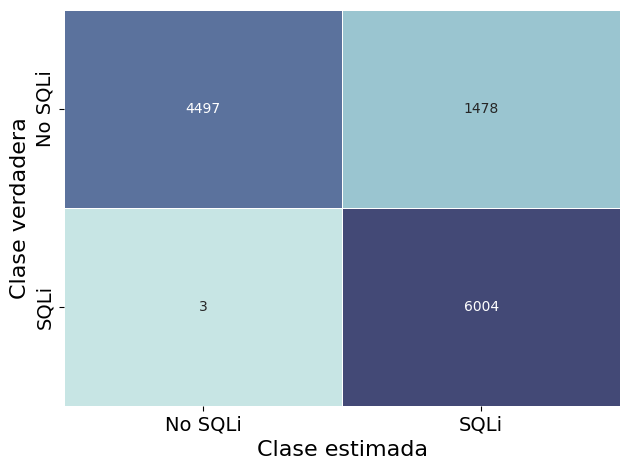

In [6]:
model_NB_name = "Gaussian Naive Bayes"      # Define the model name

t0_train_NB = time.time()                   # Start timer for training
model_NB = GaussianNB()                     # Initialize the model
model_NB.fit(X_train, y_train)              # Train the model
t_train_NB = time.time() - t0_train_NB      # Calculate training time

# Save the trained model to a file
dump(model_NB, './balanced_models/NB_duplicates.joblib')

t0_test_NB = time.time()                    # Start timer for testing
y_NB_pred = model_NB.predict(X_test)        # Make predictions on the test set
t_test_NB = time.time() - t0_test_NB        # Calculate testing time

# Evaluate the model and generate metrics
model_NB_metrics = utils.metrics(model_NB_name, y_test, y_NB_pred, main_path_images+'NB_duplicates.pdf')

# Append training and testing times to the metrics
model_NB_metrics.append(t_train_NB)
model_NB_metrics.append(t_test_NB)
result_table.append(model_NB_metrics)       # Add the metrics to the result table

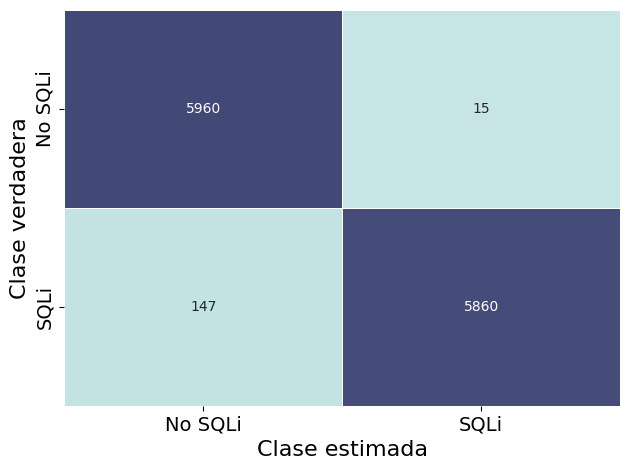

In [7]:
model_MNB_name = "Multinomial Naive Bayes"  # Define the model name

t0_train_MNB = time.time()                  # Start timer for training
model_MNB = MultinomialNB(alpha=0.1)        # Initialize the model
model_MNB.fit(X_train, y_train)             # Train the model
t_train_MNB = time.time() - t0_train_MNB    # Calculate training time

# Save the trained model to a file
dump(model_MNB, './balanced_models/MNB_duplicates.joblib')

t0_test_MNB = time.time()                   # Start timer for testing
y_MNB_pred = model_MNB.predict(X_test)      # Make predictions on the test set
t_test_MNB = time.time() - t0_test_MNB      # Calculate testing time

# Evaluate the model and generate metrics
model_MNB_metrics = utils.metrics(model_MNB_name, y_test, y_MNB_pred, main_path_images+'MNB_duplicates.pdf')

# Append training and testing times to the metrics
model_MNB_metrics.append(t_train_MNB)
model_MNB_metrics.append(t_test_MNB)
result_table.append(model_MNB_metrics)      # Add the metrics to the result table

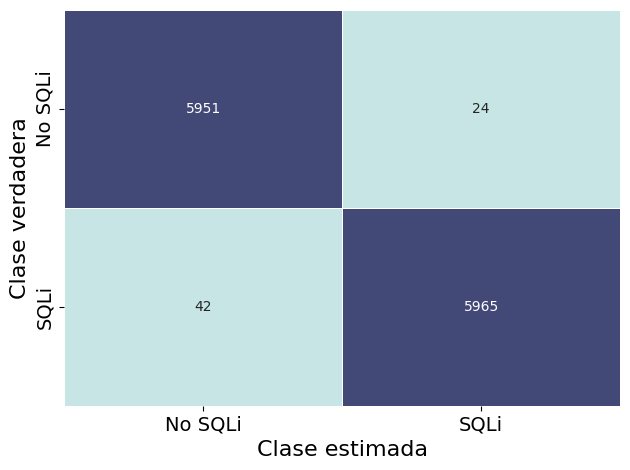

In [8]:
model_LR_name = "Logistic Regression"       # Define the model name

t0_train_LR = time.time()                   # Start timer for training
model_LR = LogisticRegression()             # Initialize the model
model_LR.fit(X_train, y_train)              # Train the model
t_train_LR = time.time() - t0_train_LR      # Calculate training time

# Save the trained model to a file
dump(model_LR, './balanced_models/LR_duplicates.joblib')

t0_test_LR = time.time()                   # Start timer for testing
y_LR_pred = model_LR.predict(X_test)       # Make predictions on the test set
t_test_LR = time.time() - t0_test_LR       # Calculate testing time

# Evaluate the model and generate metrics
model_LR_metrics = utils.metrics(model_LR_name, y_test, y_LR_pred, main_path_images+'LR_duplicates.pdf')

# Append training and testing times to the metrics
model_LR_metrics.append(t_train_LR)
model_LR_metrics.append(t_test_LR)
result_table.append(model_LR_metrics)      # Add the metrics to the result table

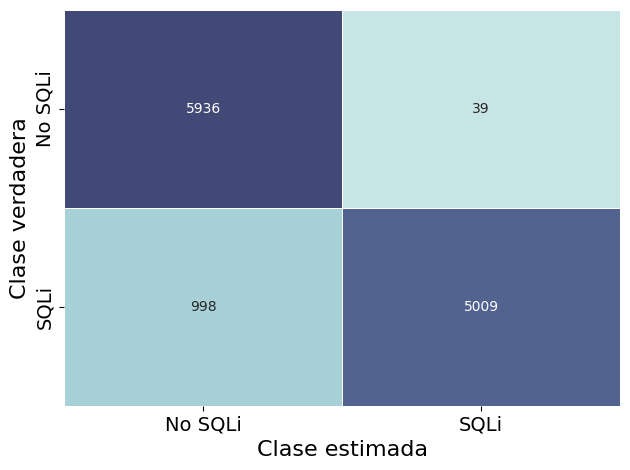

In [9]:
model_RF_name = "Random Forest"             # Define the model name

t0_train_RF = time.time()                   # Start timer for training

# Initialize the model
model_RF = RandomForestClassifier(n_estimators=23, max_depth=18, n_jobs=-1)
model_RF.fit(X_train, y_train)              # Train the model
t_train_RF = time.time() - t0_train_RF      # Calculate training time

# Save the trained model to a file
dump(model_RF, './balanced_models/RF_duplicates.joblib')

t0_test_RF = time.time()                    # Start timer for testing
y_RF_pred = model_RF.predict(X_test)        # Make predictions on the test set
t_test_RF = time.time() - t0_test_RF        # Calculate testing time

# Evaluate the model and generate metrics
model_RF_metrics = utils.metrics(model_RF_name, y_test, y_RF_pred, main_path_images+'RF_duplicates.pdf')

# Append training and testing times to the metrics
model_RF_metrics.append(t_train_RF)
model_RF_metrics.append(t_test_RF)
result_table.append(model_RF_metrics)       # Add the metrics to the result table

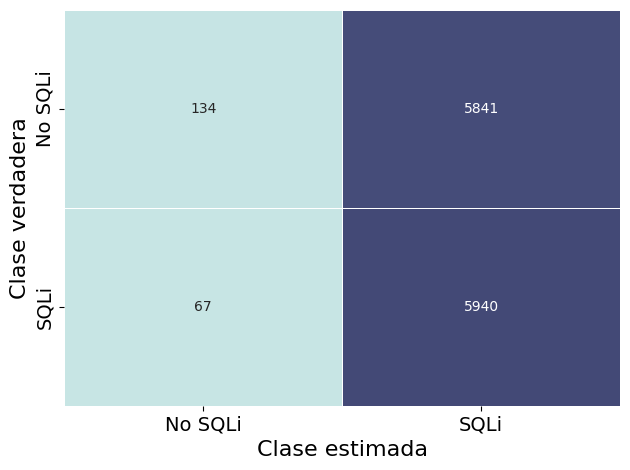

In [10]:
model_OCSVM_name = "One Class SVM"          # Define the model name

t0_train_OCSVM = time.time()                # Start timer for training

# Initialize the model
model_OCSVM = OneClassSVM(kernel="rbf", gamma='scale', nu=0.01)

model_OCSVM.fit(X_train_OCSVM)              # Train the model
t_train_OCSVM = time.time() - t0_train_OCSVM# Calculate training time

# Save the trained model to a file
dump(model_OCSVM, './balanced_models/OCSVM_duplicates.joblib')

t0_test_OCSVM = time.time()                 # Start timer for testing
y_OCSVM_pred = model_OCSVM.predict(X_test)  # Make predictions on the test set
t_test_OCSVM = time.time() - t0_test_OCSVM  # Calculate testing time

y_OCSVM_pred_mapped = np.where(y_OCSVM_pred == -1, 0, 1)

# Evaluate the model and generate metrics
model_OCSVM_metrics = utils.metrics(model_OCSVM_name, y_test, y_OCSVM_pred_mapped, main_path_images+'OCSVM_duplicates.pdf')

# Append training and testing times to the metrics
model_OCSVM_metrics.append(t_train_OCSVM)
model_OCSVM_metrics.append(t_test_OCSVM)
result_table.append(model_OCSVM_metrics)    # Add the metrics to the result table

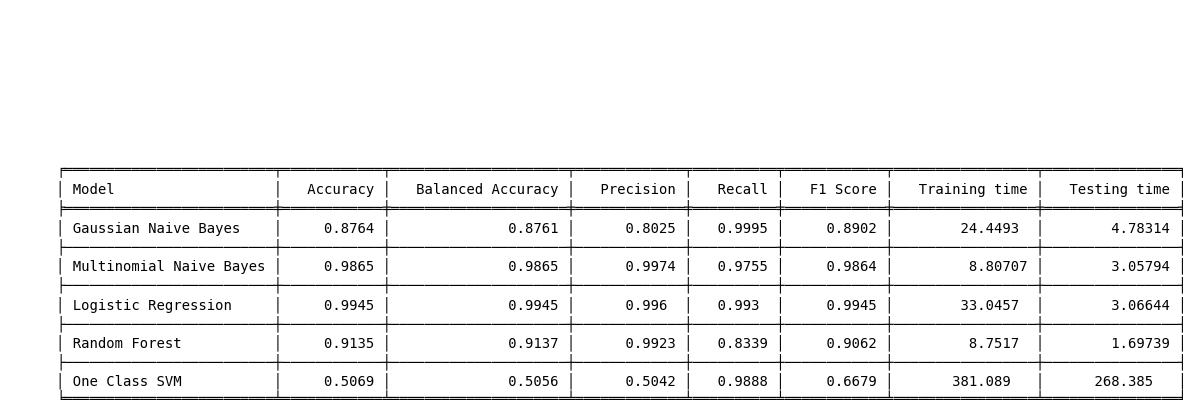

In [11]:
# Define the headers for the result table
headers_table = ["Model", "Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1 Score", "Training time","Testing time"]

# Create a formatted table using tabulate
table = tabulate(result_table, headers=headers_table, tablefmt="fancy_grid")

# Plot the table using matplotlib
plt.figure(figsize=(6, 4))
plt.text(0.1, 0.5, table, {'font': 'monospace'}, fontsize=10, va='top')
plt.axis('off')
plt.show()

# Define the file path for saving the metrics
file_table1_path = "./balanced_models/metrics_duplicates_output.txt"

# Write the result table to a text file
with open(file_table1_path, 'w') as f:
    for inner_list in result_table:
        f.write(' '.join(map(str, inner_list)) + '\n')

In [12]:
# Remove duplicate rows based on the 'preprocess_column' column, keeping the first occurrence
df_noDuplicates = df_integration.drop_duplicates(subset=['preprocess_column'], keep='first')

# Reset the index of the DataFrame after dropping duplicates
df_noDuplicates = df_noDuplicates.reset_index(drop=True)

# Display the resulting DataFrame without duplicates
df_noDuplicates

,preprocess_column,Label
0,""" or pg _ sleep ( _ _ time _ _ ) - -",1
1,create user name identified by pass 0 tempora...,1
2,and 0 = utl _ inaddr . get _ host _ addre...,1
3,select * from users where id = ' 0 ' ...,1
4,select * from users where id = 0 or 0 ...,1
...,...,...
26267,sql ' ; e into activesessions ( sessionid )...,1
26268,sql ' ; e into activesessions ( sessionid )...,1
26269,sql ' ; e into activesessions ( sessionid )...,1
26270,sql ' ; e into activesessions ( sessionid )...,1


In [13]:
# Vectorize the 'preprocess_column' using the NLP_transform function from utils with a balanced vectorizer model
df_noDuplicates_vectorized = utils.NLP_transform(
    df_noDuplicates["preprocess_column"], 
    df_noDuplicates["Label"], 
    './balanced_models/vectorizer_noDuplicates.joblib'
    )

# Separate features (X) and labels (y)
X2 = df_noDuplicates_vectorized.drop(columns=['Label'])
y2 = df_noDuplicates_vectorized['Label']

# Balance the data using the specified method, here 'RandomUnderSampler'
X2_balanced, y2_balanced = utils.balancing_data(X2, y2, 'RandomUnderSampler')

# Split the balanced data into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_balanced, y2_balanced, test_size = 0.2, random_state=1)

# Filter the training data to include only samples with label 1 for One-Class SVM training
X2_train_OCSVM = X2_train[y2_train == 1]
y2_train_OCSVM = y2_train[y2_train == 1]

result_table2 = []                           # Initialize an empty list to store results

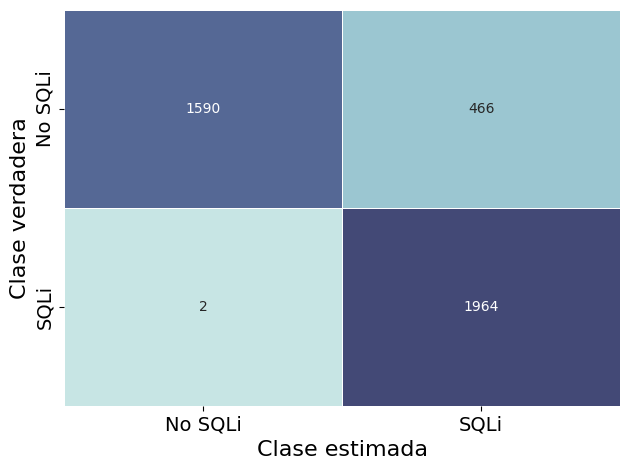

In [14]:
model2_NB_name = "Gaussian Naive Bayes"      # Define the model name

t0_train2_NB = time.time()                   # Start timer for training
model2_NB = GaussianNB()                     # Initialize the model
model2_NB.fit(X2_train, y2_train)            # Train the model
t_train2_NB = time.time() - t0_train2_NB     # Calculate training time

# Save the trained model to a file
dump(model2_NB, './balanced_models/NB_noDuplicates.joblib')

t0_test2_NB = time.time()                    # Start timer for testing
y2_NB_pred = model2_NB.predict(X2_test)      # Make predictions on the test set
t_test2_NB = time.time() - t0_test2_NB       # Calculate testing time

# Evaluate the model and generate metrics
model2_NB_metrics = utils.metrics(model2_NB_name, y2_test, y2_NB_pred, main_path_images+'NB_noDuplicates.pdf')

# Append training and testing times to the metrics
model2_NB_metrics.append(t_train2_NB)
model2_NB_metrics.append(t_test2_NB)
result_table2.append(model2_NB_metrics)      # Add the metrics to the result table


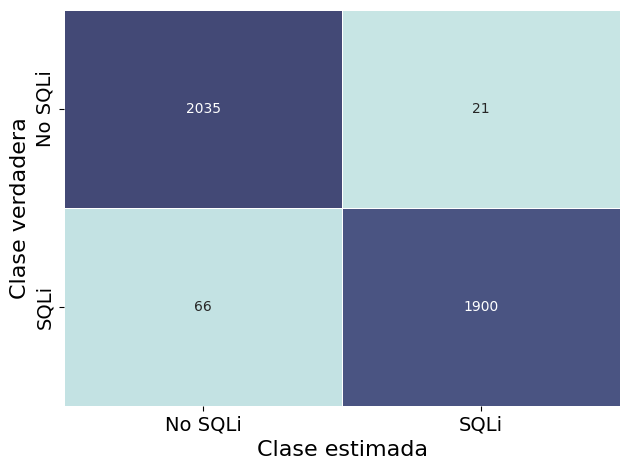

In [15]:
model2_MNB_name = "Multinomial Naive Bayes"   # Define the model name

t0_train2_MNB = time.time()                   # Start timer for training
model2_MNB = MultinomialNB(alpha=0.1)         # Initialize the model
model2_MNB.fit(X2_train, y2_train)            # Train the model
t_train2_MNB = time.time() - t0_train2_MNB    # Calculate training time

# Save the trained model to a file
dump(model2_MNB, './balanced_models/MNB_noDuplicates.joblib')

t0_test2_MNB = time.time()                    # Start timer for testing
y2_MNB_pred = model2_MNB.predict(X2_test)     # Make predictions on the test set
t_test2_MNB = time.time() - t0_test2_MNB      # Calculate testing time

# Evaluate the model and generate metrics
model2_MNB_metrics = utils.metrics(model2_MNB_name, y2_test, y2_MNB_pred, main_path_images+'MNB_noDuplicates.pdf')

# Append training and testing times to the metrics
model2_MNB_metrics.append(t_train2_MNB)
model2_MNB_metrics.append(t_test2_MNB)
result_table2.append(model2_MNB_metrics)      # Add the metrics to the result table


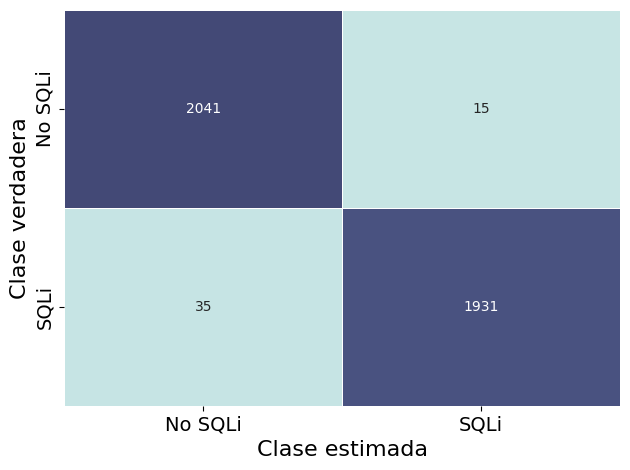

In [16]:
model2_LR_name = "Logistic Regression"       # Define the model name

t0_train2_LR = time.time()                   # Start timer for training
model2_LR = LogisticRegression()             # Initialize the model
model2_LR.fit(X2_train, y2_train)            # Train the model
t_train2_LR = time.time() - t0_train2_LR     # Calculate training time

# Save the trained model to a file
dump(model2_LR, './balanced_models/LR_noDuplicates.joblib')

t0_test2_LR = time.time()                    # Start timer for testing
y2_LR_pred = model2_LR.predict(X2_test)      # Make predictions on the test set
t_test2_LR = time.time() - t0_test2_LR       # Calculate testing time

# Evaluate the model and generate metrics
model2_LR_metrics = utils.metrics(model2_LR_name, y2_test, y2_LR_pred, main_path_images+'LR_noDuplicates.pdf')

# Append training and testing times to the metrics
model2_LR_metrics.append(t_train2_LR)
model2_LR_metrics.append(t_test2_LR)
result_table2.append(model2_LR_metrics)      # Add the metrics to the result table

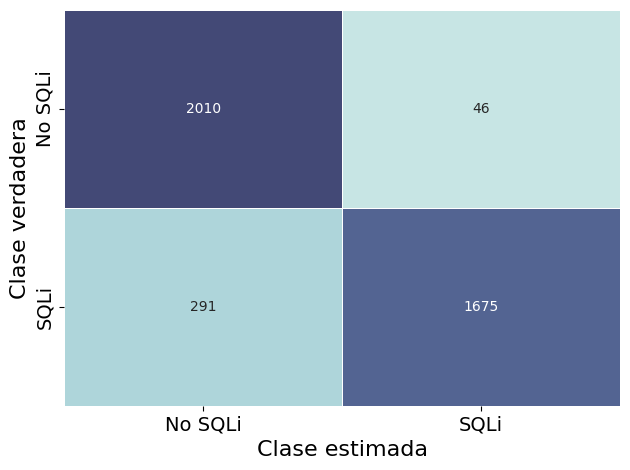

In [17]:
model2_RF_name = "Random Forest"             # Define the model name

t0_train2_RF = time.time()                   # Start timer for training

# Initialize the model
model2_RF = RandomForestClassifier(n_estimators=23, max_depth=18, n_jobs=-1)

model2_RF.fit(X2_train, y2_train)            # Train the model
t_train2_RF = time.time() - t0_train2_RF     # Calculate training time

# Save the trained model to a file
dump(model2_RF, './balanced_models/RF_noDuplicates.joblib')

t0_test2_RF = time.time()                    # Start timer for testing
y2_RF_pred = model2_RF.predict(X2_test)      # Make predictions on the test set
t_test2_RF = time.time() - t0_test2_RF       # Calculate testing time

# Evaluate the model and generate metrics
model2_RF_metrics = utils.metrics(model2_RF_name, y2_test, y2_RF_pred, main_path_images+'RF_noDuplicates.pdf')

# Append training and testing times to the metrics
model2_RF_metrics.append(t_train2_RF)
model2_RF_metrics.append(t_test2_RF)
result_table2.append(model2_RF_metrics)      # Add the metrics to the result table

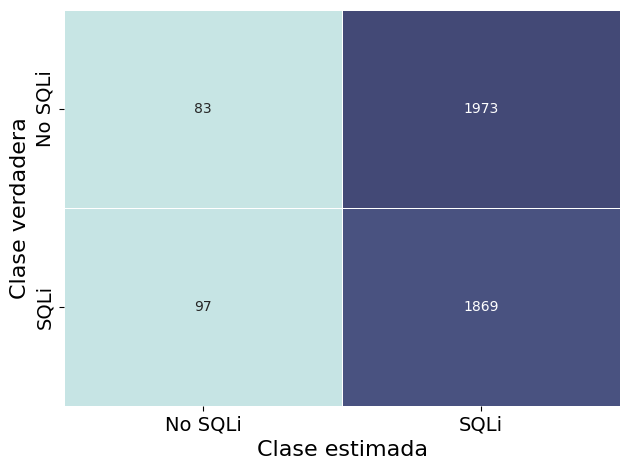

In [18]:
model2_OCSVM_name = "One Class SVM"            # Define the model name

t0_train2_OCSVM = time.time()                  # Start timer for training

# Initialize the model
model2_OCSVM = OneClassSVM(kernel="rbf", gamma='scale', nu=0.01)

model2_OCSVM.fit(X2_train_OCSVM)               # Train the model
t_train2_OCSVM = time.time() - t0_train2_OCSVM # Calculate training time

# Save the trained model to a file
dump(model2_OCSVM, './balanced_models/OCSVM_noDuplicates.joblib')

t0_test2_OCSVM = time.time()                   # Start timer for testing
y2_OCSVM_pred = model2_OCSVM.predict(X2_test)  # Make predictions on the test set
t_test2_OCSVM = time.time() - t0_test2_OCSVM   # Calculate testing time

y2_OCSVM_pred_mapped = np.where(y2_OCSVM_pred == -1, 0, 1)

# Evaluate the model and generate metrics
model2_OCSVM_metrics = utils.metrics(model2_OCSVM_name, y2_test, y2_OCSVM_pred_mapped, main_path_images+'OCSVM_noDuplicates.pdf')

# Append training and testing times to the metrics
model2_OCSVM_metrics.append(t_train2_OCSVM)
model2_OCSVM_metrics.append(t_test2_OCSVM)
result_table2.append(model2_OCSVM_metrics)     # Add the metrics to the result table

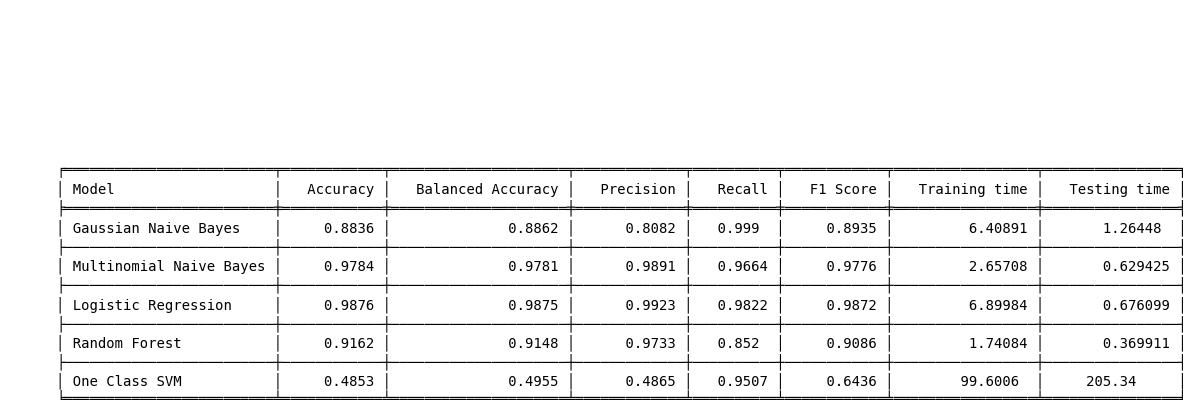

In [19]:
# Define the headers for the result table
headers_table2 = ["Model", "Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1 Score", "Training time","Testing time"]

# Create a formatted table using tabulate
table2 = tabulate(result_table2, headers=headers_table2, tablefmt="fancy_grid")

# Plot the table using matplotlib
plt.figure(figsize=(6, 4))
plt.text(0.1, 0.5, table2, {'font': 'monospace'}, fontsize=10, va='top')
plt.axis('off')
plt.show()

# Define the file path for saving the metrics
file_table2_path = "./Balanced_models/metrics_noDuplicates_output.txt"

# Write the result table to a text file
with open(file_table2_path, 'w') as f:
    for inner_list in result_table2:
        f.write(' '.join(map(str, inner_list)) + '\n')

In [20]:
tn, fp, fn, tp      = confusion_matrix(y_test, y_LR_pred).ravel()
FP_index_model_LR = []
FN_index_model_LR = []

y_test_np = np.array(y_test)

for i in range(len(y_test_np)):
    if y_LR_pred[i] != y_test_np[i]:
        if y_LR_pred[i] == 1:   # False positive
            FP_index_model_LR.append(i)
        else:                   # False negative
            FN_index_model_LR.append(i)

tn2, fp2, fn2, tp2  = confusion_matrix(y2_test, y2_LR_pred).ravel()
FP_index_model2_LR = []
FN_index_model2_LR = []

y2_test_np = np.array(y2_test)

for i in range(len(y2_test_np)):
    if y2_LR_pred[i] != y2_test_np[i]:
        if y2_LR_pred[i] == 1:  # False positive
            FP_index_model2_LR.append(i)
        else:                   # False negative
            FN_index_model2_LR.append(i)

# Calculate the percentage of overlap
overlap_FP = len(set(FP_index_model_LR).intersection(set(FP_index_model2_LR))) / len(set(FP_index_model_LR)) * 100
overlap_FN = len(set(FN_index_model_LR).intersection(set(FN_index_model2_LR))) / len(set(FN_index_model_LR)) * 100

print("Percentage of overlap in false positives between model_LR and model2_LR: {:.2f}%".format(overlap_FP))
print("Percentage of overlap in false negatives between model_LR and model2_LR: {:.2f}%".format(overlap_FN))


Percentage of overlap in false positives between model_LR and model2_LR: 0.00%
Percentage of overlap in false negatives between model_LR and model2_LR: 2.38%
